In [147]:
import numpy as np 

import sys
import os

import jax
import jax.numpy as jnp 

from jax.numpy.linalg import norm
from jax.random import uniform

from dataclasses import dataclass 
from functools import partial 


import matplotlib.pyplot as plt 

In [148]:
@partial(jax.tree_util.register_dataclass,
         data_fields=['alpha_prev', 'gamma_prev','v_prev',
                      'alpha','gamma','v', 'iter_num'],
         meta_fields=[])
@dataclass
class RPSDFactorization:
    alpha_prev: jnp.ndarray 
    gamma_prev: jnp.ndarray 
    v_prev: jnp.ndarray 

    alpha: jnp.ndarray 
    gamma: jnp.ndarray 
    v: jnp.ndarray

    iter_num: int = 0 

eps = 1e-2
key = jax.random.key(1701)

In [203]:
sigma = 1 
w = 2*5*sigma 

SNR = 0.5
K = 1000
xx = np.linspace(-5,5,64)
signal = (1/np.sqrt(2*np.pi * sigma ** 2)) * np.exp(-xx ** 2/ (2 * sigma ** 2))
std = jnp.sqrt(jnp.mean(signal**2) / SNR)

noises = np.random.normal(scale=0.2,size=(K,64))
spectrums = np.abs(np.fft.fftshift(np.fft.fft(noises,axis=1)))**2 / 64

alphas = np.clip(np.random.normal(loc=0.1, scale=0.1, size=(K,)),0,1)
psd = np.mean(spectrums,axis=0) 
samples = alphas[:,None]*signal + spectrums

freqs = np.fft.fftshift(np.fft.fftfreq(noises.shape[1]))

In [204]:
M,n = samples.shape
S = jnp.array(samples).T

norms_1 = jnp.sum(jnp.abs(S),axis=0)
v = jnp.abs(S[:,jnp.argmin(norms_1)])


norms_infty = jnp.max(jnp.abs(S),axis=1)
max_infty, min_infty = jnp.argmax(norms_infty), jnp.argmin(norms_infty)
gamma  = jnp.abs(S[:,max_infty] - S[:,min_infty])
#dists = jnp.sum(jnp.abs(S[:,None, :] - S[None,:,:]),
#                axis=2)
#indices = jnp.unravel_index(jnp.argmax(dists), dists.shape)
#gamma = jnp.abs(S[:,indices[1]] - S[:,indices[0]])

alpha = jnp.dot(gamma, S - v[...,None]) / jnp.sum(gamma**2)
alpha = jnp.clip(alpha, 0, 1)

In [205]:
from jax.numpy.linalg import norm
from jax.random import uniform


epsilon = 1e-4 

max_iter = 100 

def alternating_least_squares_convergence(state): 
    v_error = norm(state.v - state.v_prev) / norm(state.v)
    gamma_error = norm(state.gamma - state.gamma_prev) / norm(state.gamma)
    alpha_error = norm(state.alpha - state.alpha_prev) / norm(state.alpha)
    return ((v_error >= eps) | (gamma_error >= eps) | (alpha_error >= eps)) & (state.iter_num < max_iter)

def alternating_least_squares_iteration(state):
    alpha, gamma, v = state.alpha, state.gamma, state.v 

    alpha = jax.lax.cond(norm(alpha) == 0, 
                         lambda e: uniform(key, M,minval=0,maxval=1),
                         lambda e: e,
                         alpha)

    gamma_new = jnp.dot(alpha, S.T - v[None,...])/ jnp.sum(alpha ** 2)
    gamma_new = jnp.maximum(gamma_new, 0)

    v_new = S - jnp.outer(gamma_new, alpha)
    v_new = jnp.dot(v_new, jnp.ones(M)) / M
    v_new = jnp.maximum(v_new, 0)

    gamma_new = jax.lax.cond(norm(gamma_new) == 0,
                             lambda e: uniform(key, n, minval=0, maxval=1),
                             lambda e: e,
                             gamma_new)

    alpha_new = jnp.dot(gamma_new, S - v_new[...,None]) / jnp.sum(gamma_new ** 2 )
    alpha_new = jnp.clip(alpha_new, 0, 1)


    return RPSDFactorization(alpha,gamma, v,
                             alpha_new, gamma_new, v_new,
                             state.iter_num+1)

    
init_state = RPSDFactorization(jnp.zeros_like(alpha),
                            jnp.zeros_like(gamma) , 
                            jnp.zeros_like(v),
                            alpha,
                            gamma,
                            v)
f = jax.lax.while_loop(alternating_least_squares_convergence,
                                alternating_least_squares_iteration,
                                    init_state)

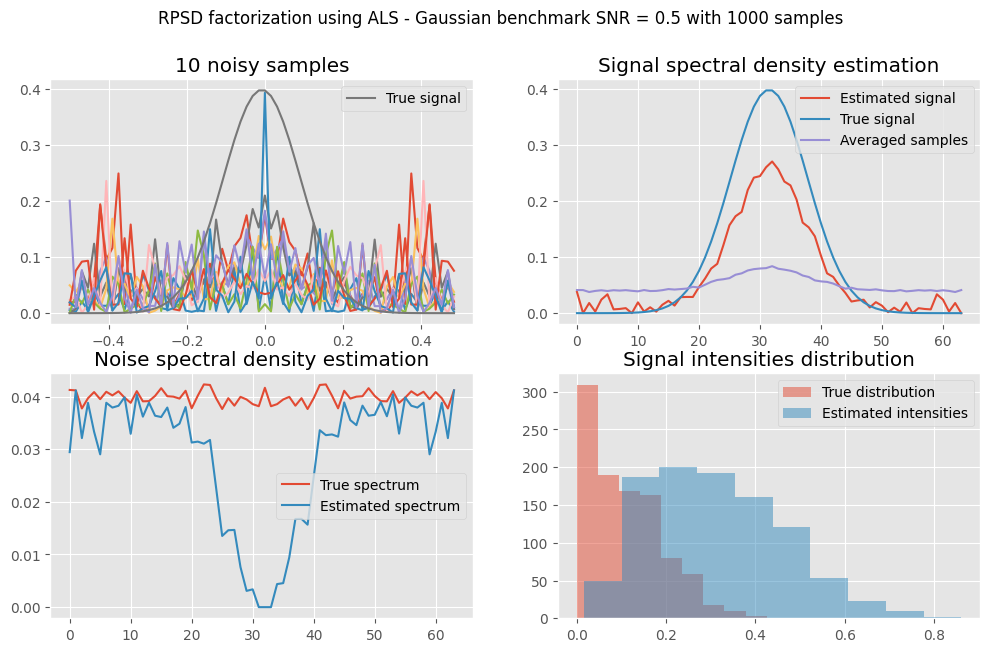

In [209]:
plt.style.use('ggplot')

fig, ax = plt.subplots(2,2, figsize=(12,7))

ax[0,0].plot(freqs, samples[:10].T);
ax[0,0].plot(freqs, signal,label='True signal')
ax[0,0].set_title("10 noisy samples")
ax[0,0].legend()

ax[0,1].plot(f.gamma,label='Estimated signal')
ax[0,1].plot(signal, label='True signal')
ax[0,1].plot(jnp.mean(samples,axis=0), label='Averaged samples')
ax[0,1].set_title("Signal spectral density estimation")
ax[0,1].legend()

ax[1,0].plot(psd, label='True spectrum')
ax[1,0].plot(f.v, label='Estimated spectrum')
ax[1,0].set_title("Noise spectral density estimation")
ax[1,0].legend()


ax[1,1].hist(alphas,label='True distribution', alpha=0.5)
ax[1,1].hist(f.alpha, label='Estimated intensities', alpha=0.5)
ax[1,1].set_title("Signal intensities distribution")
ax[1,1].legend()

plt.suptitle(f"RPSD factorization using ALS - Gaussian benchmark SNR = {SNR} with 1000 samples");